<a href="https://colab.research.google.com/github/zq343/UBS-Porject/blob/main/HD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Setting up the Environment


In [ ]:
# # Install Magnitude on Google Colab 
# ! echo "Installing Magnitude.... (please wait, can take a while)"
# ! (curl https://raw.githubusercontent.com/plasticityai/magnitude/master/install-colab.sh | /bin/bash 1>/dev/null 2>/dev/null)
# ! echo "Done installing Magnitude."

Installing Magnitude.... (please wait, can take a while)
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   137  100   137    0     0    631      0 --:--:-- --:--:-- --:--:--   631
Done installing Magnitude.


In [2]:
import numpy as np
import pandas as pd
import io
import os
import nltk
import re
import string
import math
#from pymagnitude import * 
from google.colab import files
from datetime import datetime

from sklearn.model_selection import cross_val_score,train_test_split
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor
from sklearn.metrics import mean_squared_error
import xgboost as xgb

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 1. Get the Data

In [1]:
#anaconda code
# #DATA_PATH = "./ubs/data" 

# df_train = pd.read_csv( os.path.join(DATA_PATH, "train.csv"), encoding="ISO-8859-1")
# df_test = pd.read_csv( os.path.join(DATA_PATH, "test.csv"), encoding="ISO-8859-1")
# df_pro_desc = pd.read_csv(os.path.join(DATA_PATH,'product_descriptions.csv'),encoding="ISO-8859-1")
# df_train_desc = pd.merge(df_train, df_pro_desc, how='left', on='product_uid')
# df_train_all = df_train_desc

In [2]:
#google colab code
df_train = pd.read_csv("/content/drive/My Drive/UBS/train.csv", encoding="ISO-8859-1")
df_test = pd.read_csv("/content/drive/My Drive/UBS/test.csv", encoding="ISO-8859-1")
df_pro_desc = pd.read_csv("/content/drive/My Drive/UBS/product_descriptions.csv", encoding="ISO-8859-1")

NameError: ignored

In [ ]:
# Import attributes file.
# Requires a little preprocessing since some values contain tabs
# and the file is tab delimited.
from io import StringIO
attributes_string = StringIO()
with open('/content/drive/My Drive/UBS/attributes.csv', encoding ='ISO-8859-1') as attributes_csv:
    for line in attributes_csv:
        new_line = re.sub(r'\t', '|', line.rstrip(), count=2)
        print (new_line, file=attributes_string)

# Set the index back to zero for reading
attributes_string.seek(0)

# Read in the cleaned data into an attribute dataframe object
df_attr = pd.read_csv(attributes_string)

# 2. Preposessing the Data

## 2.1 Merging Dataframes


In [156]:
df_brand = df_attr[df_attr.name == "MFG Brand Name"][["product_uid", "value"]].rename(columns={"value": "brand"})
df_brand

,product_uid,brand
9,100001.0,Simpson Strong-Tie
37,100002.0,BEHR Premium Textured DeckOver
69,100003.0,STERLING
93,100004.0,Grape Solar
122,100005.0,Delta
...,...,...
2044702,224422.0,Everbilt
2044734,224423.0,Coastal Shower Doors
2044747,224424.0,stufurhome
2044774,224425.0,Home Decorators Collection


In [157]:
df_train_all = pd.merge(df_train, df_pro_desc, how='left', on='product_uid')
df_train_all  = pd.merge(df_train_all , df_brand, how = 'left', on = 'product_uid')
df_train_all.head()

,id,product_uid,product_title,search_term,relevance,product_description,brand
0,2,100001,Simpson Strong-Tie 12-Gauge Angle,angle bracket,3.00,"Not only do angles make joints stronger, they ...",Simpson Strong-Tie
1,3,100001,Simpson Strong-Tie 12-Gauge Angle,l bracket,2.50,"Not only do angles make joints stronger, they ...",Simpson Strong-Tie
2,9,100002,BEHR Premium Textured DeckOver 1-gal. #SC-141 ...,deck over,3.00,BEHR Premium Textured DECKOVER is an innovativ...,BEHR Premium Textured DeckOver
3,16,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,rain shower head,2.33,Update your bathroom with the Delta Vero Singl...,Delta
4,17,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,shower only faucet,2.67,Update your bathroom with the Delta Vero Singl...,Delta


In [158]:
df_attr_stripped = df_attr
df_attr_stripped['name'] = df_attr_stripped['name'].apply(lambda s: re.sub(r"Bullet([0-9]+)", "", str(s)))

In [159]:
# Join the attribute name and value columns together for simplification.
# Further testing could be done with these features separate.
df_attr_stripped['attribute'] = df_attr_stripped['name'] + " " + df_attr_stripped['value']

In [160]:
# Collect the product attributes by product_uid and concatinate their 'attribute' fields into one string
# These are separated by a space for obvious processing reasons.
df_attr_group = df_attr_stripped.groupby('product_uid').agg({'attribute': lambda s : ' '.join(s.astype(str))}).reset_index()
df_attr_group.head(10)

,product_uid,attribute
0,100001.0,Versatile connector for various 90Â° connecti...
1,100002.0,"Application Method Brush,Roller,Spray Assemble..."
2,100003.0,Built-in flange Yes Slightly narrower for tig...
3,100004.0,Amperage (amps) 8.56 Positive power tolerance...
4,100005.0,Bath Faucet Type Combo Tub and Shower Built-in...
5,100006.0,Appliance Type Over the Range Microwave Assemb...
6,100007.0,Battery Power Type Ni-Cad Battery Size .Built-...
7,100008.0,Assembled Depth (in.) .375 in Assembled Height...
8,100009.0,Application Door & Window Made of primed MDF ...
9,100010.0,Attachable No Can be used with all valley Vie...


In [161]:
# Merge in the collected attributes
df_train_all = pd.merge(df_train_all, df_attr_group, how = 'left', on = 'product_uid')
df_train_all.head()

,id,product_uid,product_title,search_term,relevance,product_description,brand,attribute
0,2,100001,Simpson Strong-Tie 12-Gauge Angle,angle bracket,3.00,"Not only do angles make joints stronger, they ...",Simpson Strong-Tie,Versatile connector for various 90Â° connecti...
1,3,100001,Simpson Strong-Tie 12-Gauge Angle,l bracket,2.50,"Not only do angles make joints stronger, they ...",Simpson Strong-Tie,Versatile connector for various 90Â° connecti...
2,9,100002,BEHR Premium Textured DeckOver 1-gal. #SC-141 ...,deck over,3.00,BEHR Premium Textured DECKOVER is an innovativ...,BEHR Premium Textured DeckOver,"Application Method Brush,Roller,Spray Assemble..."
3,16,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,rain shower head,2.33,Update your bathroom with the Delta Vero Singl...,Delta,Bath Faucet Type Combo Tub and Shower Built-in...
4,17,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,shower only faucet,2.67,Update your bathroom with the Delta Vero Singl...,Delta,Bath Faucet Type Combo Tub and Shower Built-in...


In [162]:
df_train_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74067 entries, 0 to 74066
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   74067 non-null  int64  
 1   product_uid          74067 non-null  int64  
 2   product_title        74067 non-null  object 
 3   search_term          74067 non-null  object 
 4   relevance            74067 non-null  float64
 5   product_description  74067 non-null  object 
 6   brand                56439 non-null  object 
 7   attribute            56547 non-null  object 
dtypes: float64(1), int64(2), object(5)
memory usage: 5.1+ MB


In [163]:
# Defines a function which counts the number of measurement units
# which are common between each string

def str_count_common_units(dataframe):
    count = 0
    tmpWords1 = dataframe['search_term'].split()
    tmpWords2 = dataframe['product_info'].split()
    # Note that sq.ft. and cu.ft. have had ft. removed to prevent
    # overweighting of feet units
    # (Since ft. and cu.ft. both have 'ft.')
    # The set defined below is taken from the regex replacements performed
    # in the "string_edit" 
    for unit in {'in.', 'ft.', 'lb.', 'sq.', 
                 'cu.', 'gal.', 'oz.', 'cm.',
                 'mm.', 'deg.', 'volt.', 'watt.',
                 'amp.'}:
        for word1 in tmpWords1:
            for word2 in tmpWords2:
                if word1.find(unit) > -1 and word2.find(unit) > -1:
                    count += 1
        
    return count
from matplotlib import colors as mcolors
# Define a list of string representations of colors (corpus provided through matplotlib)
# This is defined outside the function to improve performance.
colors_keys = list(dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS).keys())

# Counts the number of color terms which are common between the search term instances and
# the product info instances.
# Note that product_info is comprised of title, description, and attributes.
# This feature is created in a later step.
def str_count_same_colors(dataframe):
    count = 0
    tmpWords1 = dataframe['search_term'].split()
    tmpWords2 = dataframe['product_info'].split()
    
    for word1 in tmpWords1:
        for word2 in tmpWords2:
            if word1 == word2 and word1 in colors_keys:
                count += 1
        
    return count

In [164]:
# there are enough data to work with after removing the rows with missing value
df_train_all=df_train_all.dropna()
df_train_all['product_info'] = df_train_all['search_term']+'\t'+df_train_all['product_title']+'\t'+df_train_all['product_description']+'\t'+df_train_all['attribute']

df_train_all.head()

,id,product_uid,product_title,search_term,relevance,product_description,brand,attribute,product_info
0,2,100001,Simpson Strong-Tie 12-Gauge Angle,angle bracket,3.00,"Not only do angles make joints stronger, they ...",Simpson Strong-Tie,Versatile connector for various 90Â° connecti...,angle bracket\tSimpson Strong-Tie 12-Gauge Ang...
1,3,100001,Simpson Strong-Tie 12-Gauge Angle,l bracket,2.50,"Not only do angles make joints stronger, they ...",Simpson Strong-Tie,Versatile connector for various 90Â° connecti...,l bracket\tSimpson Strong-Tie 12-Gauge Angle\t...
2,9,100002,BEHR Premium Textured DeckOver 1-gal. #SC-141 ...,deck over,3.00,BEHR Premium Textured DECKOVER is an innovativ...,BEHR Premium Textured DeckOver,"Application Method Brush,Roller,Spray Assemble...",deck over\tBEHR Premium Textured DeckOver 1-ga...
3,16,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,rain shower head,2.33,Update your bathroom with the Delta Vero Singl...,Delta,Bath Faucet Type Combo Tub and Shower Built-in...,rain shower head\tDelta Vero 1-Handle Shower O...
4,17,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,shower only faucet,2.67,Update your bathroom with the Delta Vero Singl...,Delta,Bath Faucet Type Combo Tub and Shower Built-in...,shower only faucet\tDelta Vero 1-Handle Shower...


In [165]:
# Need to create a temporary dataframe to collect the title, description, and attributes for units and color analysis
df_tmp = pd.DataFrame()
df_tmp['search_term'] = df_train_all['search_term']
df_tmp['product_info'] = df_train_all['product_title']+" "+df_train_all['product_description']+" "+df_train_all['attribute']

# New Feature: The number of common units of measurement between search terms and product_info
# Calculate the number of unit string instances that are common and store in a new feature
# Common between: search_term and (product_title + product_description + attribute)
df_train_all['num_common_units_measurement'] = df_tmp.apply(str_count_common_units, axis=1)

# New Feature: The number of common color terms between search terms and product_info
# Call the common colors function and store the result in a new feature for later use
df_train_all['num_common_colors'] = df_tmp.apply(str_count_same_colors, axis=1)

In [166]:
df_train_all.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 56439 entries, 0 to 74066
Data columns (total 11 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   id                            56439 non-null  int64  
 1   product_uid                   56439 non-null  int64  
 2   product_title                 56439 non-null  object 
 3   search_term                   56439 non-null  object 
 4   relevance                     56439 non-null  float64
 5   product_description           56439 non-null  object 
 6   brand                         56439 non-null  object 
 7   attribute                     56439 non-null  object 
 8   product_info                  56439 non-null  object 
 9   num_common_units_measurement  56439 non-null  int64  
 10  num_common_colors             56439 non-null  int64  
dtypes: float64(1), int64(4), object(6)
memory usage: 5.2+ MB


In [167]:
#saving processed file to local machine

df_train_all.to_csv('df_train_all.csv') 
files.download('df_train_all.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## 2.2 Stemming


In [58]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [60]:
#clean text
def clean_text(text):
    stopwords = nltk.corpus.stopwords.words('english')
    text = "".join([word for word in text if word not in string.punctuation])
    tokens = re.split('\W+', text)
    text = [word for word in tokens if word not in stopwords]
    return text

#stemming
ps = nltk.PorterStemmer() # define stemmer
df_all_stem = pd.DataFrame()

def stemming(tokenized_text):
    text = [ps.stem(word) for word in tokenized_text]  #return stemmed word
    return text

df_all_features = pd.DataFrame()
def str_common_word(list1, list2):
    list3 = set(list1)&set(list2) 
    list4 = sorted(list3, key = lambda k : list1.index(k))
    return len(list4)

def prepare_data (data, col_names):
  for n in col_names:
    data[n]=data[n].apply(lambda x: clean_text(x.lower()))
    data[n]=data[n].apply(lambda x: stemming(x))
    
df_all_stem=df_train_all
df_all_stem.head()

,id,product_uid,product_title,search_term,relevance,product_description,brand,attribute,product_info,num_common_units_measurement,num_common_colors
0,2,100001,Simpson Strong-Tie 12-Gauge Angle,angle bracket,3.00,"Not only do angles make joints stronger, they ...",Simpson Strong-Tie,Versatile connector for various 90Â° connecti...,angle bracket\tSimpson Strong-Tie 12-Gauge Ang...,0,0
1,3,100001,Simpson Strong-Tie 12-Gauge Angle,l bracket,2.50,"Not only do angles make joints stronger, they ...",Simpson Strong-Tie,Versatile connector for various 90Â° connecti...,l bracket\tSimpson Strong-Tie 12-Gauge Angle\t...,0,0
2,9,100002,BEHR Premium Textured DeckOver 1-gal. #SC-141 ...,deck over,3.00,BEHR Premium Textured DECKOVER is an innovativ...,BEHR Premium Textured DeckOver,"Application Method Brush,Roller,Spray Assemble...",deck over\tBEHR Premium Textured DeckOver 1-ga...,0,0
3,16,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,rain shower head,2.33,Update your bathroom with the Delta Vero Singl...,Delta,Bath Faucet Type Combo Tub and Shower Built-in...,rain shower head\tDelta Vero 1-Handle Shower O...,0,0
4,17,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,shower only faucet,2.67,Update your bathroom with the Delta Vero Singl...,Delta,Bath Faucet Type Combo Tub and Shower Built-in...,shower only faucet\tDelta Vero 1-Handle Shower...,0,0


In [61]:
df_all_stem=df_train_all.copy()
col_names=["attribute"]
col_names=["product_title","search_term","product_description","brand","attribute"]
prepare_data (df_all_stem, col_names)

In [150]:
df_all_stem.info()

,id,product_uid,product_title,search_term,relevance,product_description,brand,attribute,product_info,num_common_units_measurement,num_common_colors
0,2,100001,"[simpson, strongti, 12gaug, angl]","[angl, bracket]",3.00,"[angl, make, joint, stronger, also, provid, co...","[simpson, strongti]","[, versatil, connector, variou, 90â, connect, ...",angle bracket\tSimpson Strong-Tie 12-Gauge Ang...,0,0
1,3,100001,"[simpson, strongti, 12gaug, angl]","[l, bracket]",2.50,"[angl, make, joint, stronger, also, provid, co...","[simpson, strongti]","[, versatil, connector, variou, 90â, connect, ...",l bracket\tSimpson Strong-Tie 12-Gauge Angle\t...,0,0
2,9,100002,"[behr, premium, textur, deckov, 1gal, sc141, t...",[deck],3.00,"[behr, premium, textur, deckov, innov, solid, ...","[behr, premium, textur, deckov]","[applic, method, brushrollerspray, assembl, de...",deck over\tBEHR Premium Textured DeckOver 1-ga...,0,0
3,16,100005,"[delta, vero, 1handl, shower, faucet, trim, ki...","[rain, shower, head]",2.33,"[updat, bathroom, delta, vero, singlehandl, sh...",[delta],"[bath, faucet, type, combo, tub, shower, built...",rain shower head\tDelta Vero 1-Handle Shower O...,0,0
4,17,100005,"[delta, vero, 1handl, shower, faucet, trim, ki...","[shower, faucet]",2.67,"[updat, bathroom, delta, vero, singlehandl, sh...",[delta],"[bath, faucet, type, combo, tub, shower, built...",shower only faucet\tDelta Vero 1-Handle Shower...,0,0
...,...,...,...,...,...,...,...,...,...,...,...
74062,221457,206638,"[atlant, windowpan, 576, cd, 192, dvd, bluray,...","[tv, riser, glass]",1.00,"[atlant, inc, 94835722, uniqu, design, maximum...",[atlant],"[assembl, depth, 95, assembl, height, 49, asse...",tv riser glass\tAtlantic Windowpane 576 CD or ...,0,0
74063,221458,206639,"[philip, 40watt, halogen, r20, flood, light, b...","[r20, halogen, light]",3.00,"[philip, energi, advantag, lamp, use, less, en...",[philip],"[actual, color, temperatur, k, 2700, averag, l...",r20 halogen light\tPhilips 40-Watt Halogen R20...,0,0
74064,221463,206641,"[schlage, camelot, inact, age, bronz, handlese...","[schlage, lock, siena, half, dummi, knob]",2.33,"[schlage, camelot, inact, age, bronz, handlese...",[schlage],"[applic, type, entri, assembl, depth, 29, asse...",schlage lock siena half dummy knob with\tSchla...,0,0
74065,221471,206648,"[plastec, 11, x, 24, rose, garden, wall, decor...","[zen, garden, decor]",3.00,"[rose, garden, inspir, popular, earli, 20th, c...",[plastec],"[, indoor, outdoor, use, finish, dark, bronz, ...",zen garden decor\tPlastec 11 in. x 24 in. Ros...,0,0


## 2.3. Creating New Features

In [63]:
df_all_features = df_all_stem.copy()
def str_common_word(str1, str2):
    return sum(int(str2.find(word)>=0) for word in str1.split())
df_all_features.head()

,id,product_uid,product_title,search_term,relevance,product_description,brand,attribute,product_info,num_common_units_measurement,num_common_colors
0,2,100001,"[simpson, strongti, 12gaug, angl]","[angl, bracket]",3.00,"[angl, make, joint, stronger, also, provid, co...","[simpson, strongti]","[, versatil, connector, variou, 90â, connect, ...",angle bracket\tSimpson Strong-Tie 12-Gauge Ang...,0,0
1,3,100001,"[simpson, strongti, 12gaug, angl]","[l, bracket]",2.50,"[angl, make, joint, stronger, also, provid, co...","[simpson, strongti]","[, versatil, connector, variou, 90â, connect, ...",l bracket\tSimpson Strong-Tie 12-Gauge Angle\t...,0,0
2,9,100002,"[behr, premium, textur, deckov, 1gal, sc141, t...",[deck],3.00,"[behr, premium, textur, deckov, innov, solid, ...","[behr, premium, textur, deckov]","[applic, method, brushrollerspray, assembl, de...",deck over\tBEHR Premium Textured DeckOver 1-ga...,0,0
3,16,100005,"[delta, vero, 1handl, shower, faucet, trim, ki...","[rain, shower, head]",2.33,"[updat, bathroom, delta, vero, singlehandl, sh...",[delta],"[bath, faucet, type, combo, tub, shower, built...",rain shower head\tDelta Vero 1-Handle Shower O...,0,0
4,17,100005,"[delta, vero, 1handl, shower, faucet, trim, ki...","[shower, faucet]",2.67,"[updat, bathroom, delta, vero, singlehandl, sh...",[delta],"[bath, faucet, type, combo, tub, shower, built...",shower only faucet\tDelta Vero 1-Handle Shower...,0,0


In [64]:
#adding new features
df_all_features['len_of_query'] = df_all_features['search_term'].map(lambda x:len(x)).astype(np.int64)
df_all_features['word_in_title'] = df_all_features['product_info'].map(lambda x:str_common_word(x[0],x[1]))
df_all_features['word_in_description'] = df_all_features['product_info'].map(lambda x:str_common_word(x[0],x[2]))
df_all_features['len_of_brand'] = df_all_features['brand'].map(lambda x:len(str(x).split())).astype(np.int64)
df_all_features['len_of_attribute'] = df_all_features['attribute'].map(lambda x:len(str(x).split())).astype(np.int64)
df_all_features['word_in_title'] = df_all_features['product_info'].map(lambda x:str_common_word(str(x).split('\t')[0],str(x).split('\t')[1]))
df_all_features['word_in_description'] = df_all_features['product_info'].map(lambda x:str_common_word(str(x).split('\t')[0],str(x).split('\t')[2]))
df_all_features['word_in_attributes'] = df_all_features['product_info'].map(lambda x:str_common_word(str(x).split('\t')[0],str(x).split('\t')[3]))
df_all_features['attr'] = str(df_all_features['search_term'])+"\t"+str(df_all_features['brand'])
df_all_features['brand_in_search'] = df_all_features['attr'].map(lambda x:str_common_word(str(x).split('\t')[0],str(x).split('\t')[1]))
df_all_features['ratio_brand'] = df_all_features['brand_in_search']/df_all_features['len_of_brand']
df_all_features['last_word_title_match'] = df_all_features['product_info'].map(lambda x:str_common_word(str(x).split('\t')[0].split(" ")[-1],str(x).split('\t')[1]))
df_all_features['last_word_description_match'] = df_all_features['product_info'].map(lambda x:str_common_word(str(x).split('\t')[0].split(" ")[-1],str(x).split('\t')[2]))
df_all_features['first_word_title_match'] = df_all_features['product_info'].map(lambda x:str_common_word(str(x).split('\t')[0].split(" ")[0],str(x).split('\t')[1]))
df_all_features['first_word_description_match'] = df_all_features['product_info'].map(lambda x:str_common_word(str(x).split('\t')[0].split(" ")[0],x.split('\t')[2]))

df_all_features.head()

,id,product_uid,product_title,search_term,relevance,product_description,brand,attribute,product_info,num_common_units_measurement,num_common_colors,len_of_query,word_in_title,word_in_description,len_of_brand,len_of_attribute,word_in_attributes,attr,brand_in_search,ratio_brand,last_word_title_match,last_word_description_match,first_word_title_match,first_word_description_match
0,2,100001,"[simpson, strongti, 12gaug, angl]","[angl, bracket]",3.00,"[angl, make, joint, stronger, also, provid, co...","[simpson, strongti]","[, versatil, connector, variou, 90â, connect, ...",angle bracket\tSimpson Strong-Tie 12-Gauge Ang...,0,0,2,0,1,2,70,1,"0 [angl, brac...",16,8.0,0,0,0,1
1,3,100001,"[simpson, strongti, 12gaug, angl]","[l, bracket]",2.50,"[angl, make, joint, stronger, also, provid, co...","[simpson, strongti]","[, versatil, connector, variou, 90â, connect, ...",l bracket\tSimpson Strong-Tie 12-Gauge Angle\t...,0,0,2,1,1,2,70,1,"0 [angl, brac...",16,8.0,0,0,1,1
2,9,100002,"[behr, premium, textur, deckov, 1gal, sc141, t...",[deck],3.00,"[behr, premium, textur, deckov, innov, solid, ...","[behr, premium, textur, deckov]","[applic, method, brushrollerspray, assembl, de...",deck over\tBEHR Premium Textured DeckOver 1-ga...,0,0,1,0,2,4,158,2,"0 [angl, brac...",16,4.0,0,1,0,1
3,16,100005,"[delta, vero, 1handl, shower, faucet, trim, ki...","[rain, shower, head]",2.33,"[updat, bathroom, delta, vero, singlehandl, sh...",[delta],"[bath, faucet, type, combo, tub, shower, built...",rain shower head\tDelta Vero 1-Handle Shower O...,0,0,3,0,0,1,120,2,"0 [angl, brac...",16,16.0,0,0,0,0
4,17,100005,"[delta, vero, 1handl, shower, faucet, trim, ki...","[shower, faucet]",2.67,"[updat, bathroom, delta, vero, singlehandl, sh...",[delta],"[bath, faucet, type, combo, tub, shower, built...",shower only faucet\tDelta Vero 1-Handle Shower...,0,0,2,0,1,1,120,2,"0 [angl, brac...",16,16.0,0,0,0,0


In [65]:
#saving processed file to local machine

df_all_features.to_csv('df_all_features.csv') 
files.download('df_all_features.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [66]:
df_all_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 56439 entries, 0 to 74066
Data columns (total 24 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   id                            56439 non-null  int64  
 1   product_uid                   56439 non-null  int64  
 2   product_title                 56439 non-null  object 
 3   search_term                   56439 non-null  object 
 4   relevance                     56439 non-null  float64
 5   product_description           56439 non-null  object 
 6   brand                         56439 non-null  object 
 7   attribute                     56439 non-null  object 
 8   product_info                  56439 non-null  object 
 9   num_common_units_measurement  56439 non-null  int64  
 10  num_common_colors             56439 non-null  int64  
 11  len_of_query                  56439 non-null  int64  
 12  word_in_title                 56439 non-null  int64  
 13  w

In [67]:
df_all_no_emb=df_all_features.copy()
emb_features=["product_title",'search_term',"product_description","brand","attribute","product_info",'attr']
df_all_no_emb=df_all_no_emb.drop(labels=emb_features,axis=1)

In [68]:
df_all_no_emb.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 56439 entries, 0 to 74066
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   id                            56439 non-null  int64  
 1   product_uid                   56439 non-null  int64  
 2   relevance                     56439 non-null  float64
 3   num_common_units_measurement  56439 non-null  int64  
 4   num_common_colors             56439 non-null  int64  
 5   len_of_query                  56439 non-null  int64  
 6   word_in_title                 56439 non-null  int64  
 7   word_in_description           56439 non-null  int64  
 8   len_of_brand                  56439 non-null  int64  
 9   len_of_attribute              56439 non-null  int64  
 10  word_in_attributes            56439 non-null  int64  
 11  brand_in_search               56439 non-null  int64  
 12  ratio_brand                   56439 non-null  float64
 13  l

In [69]:
df_all_no_emb.to_csv('df_all_no_emb.csv') 
files.download('df_all_no_emb.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# 3. Average Word Embedding

In [ ]:
!wget http://magnitude.plasticity.ai/word2vec/heavy/GoogleNews-vectors-negative300.magnitude


--2020-09-28 15:28:34--  http://magnitude.plasticity.ai/word2vec/heavy/GoogleNews-vectors-negative300.magnitude
Resolving magnitude.plasticity.ai (magnitude.plasticity.ai)... 52.216.106.34
Connecting to magnitude.plasticity.ai (magnitude.plasticity.ai)|52.216.106.34|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10745409536 (10G) [binary/octet-stream]
Saving to: ‘GoogleNews-vectors-negative300.magnitude’

GoogleNews-vectors- 100%[===================>]  10.01G  40.6MB/s    in 4m 12s  

2020-09-28 15:32:46 (40.7 MB/s) - ‘GoogleNews-vectors-negative300.magnitude’ saved [10745409536/10745409536]



In [ ]:
vectors = Magnitude("GoogleNews-vectors-negative300.magnitude")

In [ ]:
# Use customized embedding techinique - mean of similarities
def sim_score(sim_vec):
    sim_score = []
    for a in sim_vec:
        mean = np.mean(a) 
        sim_score.append(mean)
    return np.mean(sim_score) 

def get_sim_score(A,B):
    #A,B are lists of 
    sim_score_list = []
    for i in range(len(A)):
        #print(B[i])
        try:
            sim_score_list.append(sim_score(vectors.similarity(A[i],B[i])))
        except:
            #print(B[i])
            sim_score_list.append(0) #if one of the list is empty, means no word in it. Return 0 similarity
    return sim_score_list

# def avg_word_embedding(Data, word_col_names, name, Ret_Data):
#   for c in word_col_names:
#     tmp =get_sim_score(list(Data[c]),list(Data[name]))
#     tmp2= str(c)+ "sim"
#     Ret_Data[tmp2]=tmp

In [ ]:

# df_emb = pd.DataFrame()
# word_col_names = ['brand',"attribute",'product_title','product_description']
# avg_word_embedding(df_all_stem, word_col_names,'search_term', df_emb)


In [ ]:
# df_emb = pd.DataFrame()
# product_brand_emb = get_sim_score(list(df_all_stem['brand']),list(df_all_stem['search_term']))
# df_emb['brand_sim'] = product_brand_emb 

In [ ]:
# attr_emb = get_sim_score(list(df_all_stem['attribute']),list(df_all_stem['search_term']))
# df_emb['attr_sim'] = attr_emb

In [ ]:
# product_title_emb = get_sim_score(list(df_all_stem['product_title']),list(df_all_stem['search_term']))
# df_emb['title_sim'] = product_title_emb

In [ ]:
# description_emb = get_sim_score(list(df_all_stem['product_description']),list(df_all_stem['search_term']))
# df_emb['description_sim'] = description_emb

In [ ]:
# df_emb.head()

,brand_sim,attr_sim,title_sim,description_sim
0,0.046150,0.012028,0.099485,0.011724
1,0.089695,0.011272,0.056404,0.009350
2,0.080348,0.010224,0.043307,0.011489
3,0.048004,0.007526,0.036266,0.009092
4,0.108503,0.014926,0.077293,0.016911


In [ ]:
# #saving word embedding file to local machine
# df_emb.to_csv('hd_avg_word.csv') 
# files.download('hd_avg_word.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#import the Word2Vec embedding features
df_avg_word = pd.read_csv( "/content/drive/My Drive/UBS/hd_avg_word.csv", index_col=0)
df_avg_word.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 56439 entries, 0 to 56438
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   brand_sim        56439 non-null  float64
 1   attr_sim         56439 non-null  float64
 2   title_sim        56439 non-null  float64
 3   description_sim  56439 non-null  float64
dtypes: float64(4)
memory usage: 2.2 MB


In [ ]:
df_all_avg_word = df_all_no_emb.copy()
df_all_avg_word.info()
#df_all_avg_word=pd.concat([df_all_avg_word,df_avg_word],axis=1)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 56439 entries, 0 to 74066
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   id                            56439 non-null  int64  
 1   product_uid                   56439 non-null  int64  
 2   relevance                     56439 non-null  float64
 3   num_common_units_measurement  56439 non-null  int64  
 4   num_common_colors             56439 non-null  int64  
 5   len_of_query                  56439 non-null  int64  
 6   word_in_title                 56439 non-null  int64  
 7   word_in_description           56439 non-null  int64  
 8   len_of_brand                  56439 non-null  int64  
 9   len_of_attribute              56439 non-null  int64  
 10  word_in_attributes            56439 non-null  int64  
 11  brand_in_search               56439 non-null  int64  
 12  ratio_brand                   56439 non-null  float64
 13  l

In [ ]:
#add the embedding features
df_all_avg_word ["brand_sim"]=df_avg_word["brand_sim"]
df_all_avg_word ["attr_sim"]=df_avg_word["attr_sim"]
df_all_avg_word ["title_sim"]=df_avg_word["title_sim"]
df_all_avg_word ["description_sim"]=df_avg_word["description_sim"]
df_all_avg_word 

,id,product_uid,relevance,num_common_units_measurement,num_common_colors,len_of_query,word_in_title,word_in_description,len_of_brand,len_of_attribute,word_in_attributes,brand_in_search,ratio_brand,last_word_title_match,last_word_description_match,first_word_title_match,first_word_description_match,brand_sim,attr_sim,title_sim,description_sim
0,2,100001,3.00,0,0,2,0,1,2,70,1,16,8.0,0,0,0,1,0.046150,0.012028,0.099485,0.011724
1,3,100001,2.50,0,0,2,1,1,2,70,1,16,8.0,0,0,1,1,0.089695,0.011272,0.056404,0.009350
2,9,100002,3.00,0,0,1,0,2,4,158,2,16,4.0,0,1,0,1,0.080348,0.010224,0.043307,0.011489
3,16,100005,2.33,0,0,3,0,0,1,120,2,16,16.0,0,0,0,0,0.048004,0.007526,0.036266,0.009092
4,17,100005,2.67,0,0,2,0,1,1,120,2,16,16.0,0,0,0,0,0.108503,0.014926,0.077293,0.016911
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74062,221457,206638,1.00,0,0,3,0,1,1,119,1,16,16.0,0,1,0,0,NaN,NaN,NaN,NaN
74063,221458,206639,3.00,0,0,3,0,2,1,128,1,16,16.0,0,1,0,0,NaN,NaN,NaN,NaN
74064,221463,206641,2.33,0,0,6,1,2,1,221,2,16,16.0,1,1,0,0,NaN,NaN,NaN,NaN
74065,221471,206648,3.00,0,0,3,0,1,1,51,1,16,16.0,0,1,0,0,NaN,NaN,NaN,NaN


In [ ]:
# dropping missing entries
df_all_avg_word=df_all_avg_word.dropna()
df_all_avg_word.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40024 entries, 0 to 56438
Data columns (total 21 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   id                            40024 non-null  int64  
 1   product_uid                   40024 non-null  int64  
 2   relevance                     40024 non-null  float64
 3   num_common_units_measurement  40024 non-null  int64  
 4   num_common_colors             40024 non-null  int64  
 5   len_of_query                  40024 non-null  int64  
 6   word_in_title                 40024 non-null  int64  
 7   word_in_description           40024 non-null  int64  
 8   len_of_brand                  40024 non-null  int64  
 9   len_of_attribute              40024 non-null  int64  
 10  word_in_attributes            40024 non-null  int64  
 11  brand_in_search               40024 non-null  int64  
 12  ratio_brand                   40024 non-null  float64
 13  l

In [ ]:
# df_all_avg_word.to_csv('df_all_avg.csv') 
# files.download('df_all_avg.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# 4. TF-IDF


In [72]:
df_all_features = pd.read_csv("/content/drive/My Drive/UBS/df_all_features.csv", encoding="ISO-8859-1", index_col=0)

In [73]:
df_all_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 56439 entries, 0 to 74066
Data columns (total 24 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   id                            56439 non-null  int64  
 1   product_uid                   56439 non-null  int64  
 2   product_title                 56439 non-null  object 
 3   search_term                   56439 non-null  object 
 4   relevance                     56439 non-null  float64
 5   product_description           56439 non-null  object 
 6   brand                         56439 non-null  object 
 7   attribute                     56439 non-null  object 
 8   product_info                  56439 non-null  object 
 9   num_common_units_measurement  56439 non-null  int64  
 10  num_common_colors             56439 non-null  int64  
 11  len_of_query                  56439 non-null  int64  
 12  word_in_title                 56439 non-null  int64  
 13  w

In [74]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import FeatureUnion, Pipeline
# TF-IDF and Truncated SVD initialization (to extract concept using Latent semantics analysis(LSA))
tfidf = TfidfVectorizer(ngram_range=(1, 2), stop_words='english') #stop words
svd = TruncatedSVD(n_components=100, random_state = 2019)  #n_components=100 to extract concepts using LSA
pipe = Pipeline(steps=[('tfidf', tfidf), ('svd', svd)])

In [75]:
# Perform fit and transform function of pipeline to convert text(in each feature) into vectors and reducing them 
df_tf=df_all_features.copy()
# Transform all object columns
obj_col=[]
for (columnName, columnData) in df_tf.iteritems(): 
  if df_tf[columnName].dtypes==object:
    df_tf[columnName]=pipe.fit_transform(df_tf[columnName])
df_tf.head()

,id,product_uid,product_title,search_term,relevance,product_description,brand,attribute,product_info,num_common_units_measurement,num_common_colors,len_of_query,word_in_title,word_in_description,len_of_brand,len_of_attribute,word_in_attributes,attr,brand_in_search,ratio_brand,last_word_title_match,last_word_description_match,first_word_title_match,first_word_description_match
0,2,100001,0.006560,0.003661,3.00,0.063656,1.044391e-10,0.091004,0.071732,0,0,2,0,1,2,70,1,1.0,16,8.0,0,0,0,1
1,3,100001,0.006560,0.006449,2.50,0.063656,1.044355e-10,0.091004,0.071668,0,0,2,1,1,2,70,1,1.0,16,8.0,0,0,1,1
2,9,100002,0.013937,0.006368,3.00,0.126209,1.980652e-09,0.165142,0.148984,0,0,1,0,2,4,158,2,1.0,16,4.0,0,1,0,1
3,16,100005,0.055361,0.034519,2.33,0.082506,3.420864e-15,0.175849,0.144528,0,0,3,0,0,1,120,2,1.0,16,16.0,0,0,0,0
4,17,100005,0.055361,0.070724,2.67,0.082506,3.368701e-15,0.175849,0.144744,0,0,2,0,1,1,120,2,1.0,16,16.0,0,0,0,0


In [77]:
# #saving tf idf embedding file to local machine
# df_tf.to_csv('hd_tf.csv') 
# files.download('hd_tf.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# 5. Sentence Embedding


In [139]:
"""
Pretrain models on sentence embedding
https://github.com/Separius/awesome-sentence-embedding#encoders

"""

'\nPretrain models on sentence embedding\nhttps://github.com/Separius/awesome-sentence-embedding#encoders\n'

In [5]:
from sentence_transformers import SentenceTransformer, util
import torch
embedder = SentenceTransformer('distilbert-base-nli-stsb-mean-tokens')

100%|██████████| 245M/245M [00:06<00:00, 38.1MB/s]


In [11]:
# device = torch.device("cuda:0")
# print(torch.cuda.device_count())

1


In [7]:
df_sent = pd.read_csv("/content/drive/My Drive/UBS/df_train_all.csv", encoding="ISO-8859-1", index_col=0)

In [6]:
#pip install -U sentence-transformers

In [8]:
def sent_emb(query_col, df, corpus_col):
  sent_emb=[]
  n=df.shape[0]
  # for row in range(n):
  for row in range(n):
    corpus=df.iloc[row][corpus_col]
    query=df.iloc[row][query_col]
    corpus_embeddings = embedder.encode(corpus, convert_to_tensor=True)
    query_embedding = embedder.encode(query, convert_to_tensor=True)
    cos_scores = util.pytorch_cos_sim(query_embedding, corpus_embeddings)[0]
    cos_scores = cos_scores.cpu().item()
    sent_emb.append(cos_scores)
      #query_vec = model.encode(df.iloc[row][query])[0]
  return sent_emb

In [36]:
df_sent.info()
word_col_names = ['brand',"attribute",'product_title','product_description']

<class 'pandas.core.frame.DataFrame'>
Int64Index: 56439 entries, 0 to 74066
Data columns (total 11 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   id                            56439 non-null  int64  
 1   product_uid                   56439 non-null  int64  
 2   product_title                 56439 non-null  object 
 3   search_term                   56439 non-null  object 
 4   relevance                     56439 non-null  float64
 5   product_description           56439 non-null  object 
 6   brand                         56439 non-null  object 
 7   attribute                     56439 non-null  object 
 8   product_info                  56439 non-null  object 
 9   num_common_units_measurement  56439 non-null  int64  
 10  num_common_colors             56439 non-null  int64  
dtypes: float64(1), int64(4), object(6)
memory usage: 5.2+ MB


In [45]:
df_sent_emb = pd.DataFrame()

product_title_emb = sent_emb('search_term',df_sent,'product_title')
df_sent_emb['title_sent']=product_title_emb

In [ ]:
product_desc_emb = sent_emb('search_term',df_sent,'product_description')
df_sent_emb['desc_sent']=product_desc_emb 

In [ ]:
attribute_emb = sent_emb('search_term',df_sent,'attribute')
df_sent_emb['attr_sent']=attribute_emb

In [ ]:
brand_emb = sent_emb('search_term',df_sent,'brand')
df_sent_emb['brand_sent']=brand_emb

In [13]:
df_sent_emb

,title_sent,desc_sent,attr_sent,brand_sent
0,0.268432,0.196211,0.088577,0.195731
1,0.142207,0.157782,0.110434,0.173621
2,0.288776,0.140190,0.035634,0.383535
3,0.016940,0.106550,0.135462,0.308229
4,0.663730,0.593988,0.590545,0.088269
...,...,...,...,...
56434,0.340043,0.235630,0.088616,0.158531
56435,0.608579,0.383637,0.312123,0.270859
56436,0.364812,0.204493,0.292375,0.387411
56437,0.502652,0.447396,0.364241,0.052004


In [64]:
df_all_no_emb = pd.read_csv("/content/drive/My Drive/UBS/df_all_no_emb.csv", encoding="ISO-8859-1", index_col=0)
df_sent_emb = pd.read_csv("/content/drive/My Drive/UBS/df_sent_emb.csv", encoding="ISO-8859-1", index_col=0)


In [65]:
df=df_all_no_emb.copy()

In [ ]:
# obj_col=[]
# for (columnName, columnData) in df_all_no_emb.iteritems(): 
#   if df_all_no_emb[columnName].dtypes==object: 
#     obj_col.append(columnName)
# df_all_no_emb=df_all_no_emb.drop(obj_col, axis=1)

In [66]:
for (columnName, columnData) in df_sent_emb.iteritems(): 
  df[columnName]= df_sent_emb[columnName]

In [61]:
df=pd.concat([df, df_sent_emb,], axis=1)

In [68]:
df=df.dropna()

In [69]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40024 entries, 0 to 56438
Data columns (total 21 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   id                            40024 non-null  int64  
 1   product_uid                   40024 non-null  int64  
 2   relevance                     40024 non-null  float64
 3   num_common_units_measurement  40024 non-null  int64  
 4   num_common_colors             40024 non-null  int64  
 5   len_of_query                  40024 non-null  int64  
 6   word_in_title                 40024 non-null  int64  
 7   word_in_description           40024 non-null  int64  
 8   len_of_brand                  40024 non-null  int64  
 9   len_of_attribute              40024 non-null  int64  
 10  word_in_attributes            40024 non-null  int64  
 11  brand_in_search               40024 non-null  int64  
 12  ratio_brand                   40024 non-null  float64
 13  l

In [70]:
#saving sentence embedding file to local machine
df.to_csv('df_sent_emb.csv') 
files.download('df_sent_emb.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# 5. Train Model

## 5.1 Train-Test Split

In [71]:
#loading previously calculated data frames
df_all_avg_word = pd.read_csv("/content/drive/My Drive/UBS/df_all_avg.csv", encoding="ISO-8859-1", index_col=0)
df_all_no_emb=pd.read_csv("/content/drive/My Drive/UBS/df_all_no_emb.csv", encoding="ISO-8859-1", index_col=0)
df_tf=pd.read_csv("/content/drive/My Drive/UBS/hd_tf.csv", encoding="ISO-8859-1", index_col=0)
df_sent_emb=pd.read_csv("/content/drive/My Drive/UBS/df_sent_emb.csv", encoding="ISO-8859-1", index_col=0)

In [85]:
X1 = df_all_no_emb.drop('relevance',axis=1)
y1 = df_all_no_emb['relevance'].values

#X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.33, random_state=42)

In [86]:
X2 = df_all_avg_word.drop('relevance',axis=1)
y2 = df_all_avg_word['relevance'].values

#X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.33, random_state=42)

In [75]:
X3 = df_tf.drop('relevance',axis=1)
y3 = df_tf['relevance'].values

In [73]:
X4 = df_sent_emb.drop('relevance',axis=1)
y4 = df_sent_emb['relevance'].values

## 5.2 Random Forest

### 5.2.1 No Embeddings

In [96]:
#Random forest
rf = RandomForestRegressor(n_estimators=15, max_depth=6, random_state=0)
tmp=datetime.now()
rf.fit(X1, y1)
print(math.sqrt(-cross_val_score(rf, X1, y1, scoring='neg_mean_squared_error', cv=10).mean()))
print((datetime.now()-tmp).total_seconds())

#for other scoring methods 
#see https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter

#y1_pred_rf = rf.predict(X1_test)
#print(math.sqrt(mean_squared_error(y1_test, y1_pred_rf)))
#CV_score_rf = cross_val_score(rf, X1_train, y1_train, scoring='neg_mean_squared_error', cv=10)
#math.sqrt(-CV_score_rf.mean()) #root mean squared error

0.5188235502114964
14.986599


In [97]:
clf = BaggingRegressor(rf, n_estimators=45, max_samples=0.1, random_state=25)
tmp=datetime.now()
clf.fit(X1, y1)
#y1_pred_clf = clf.predict(X1_test)

# #out of sample result
# print(math.sqrt(mean_squared_error(y1_test, y1_pred_clf)))
#in-sample result
print(math.sqrt(-cross_val_score(clf, X1, y1, scoring='neg_mean_squared_error', cv=10).mean()))
print((datetime.now()-tmp).total_seconds())

0.5173451642008592
83.973682


### 5.2.2 Avg Word

In [98]:
#Random forest
rf = RandomForestRegressor(n_estimators=15, max_depth=6, random_state=0)
tmp=datetime.now()
rf.fit(X2, y2)
#y2_pred_rf = rf.predict(X2_test)
#print(math.sqrt(mean_squared_error(y2_test, y2_pred_rf)))
print(math.sqrt(-cross_val_score(rf, X2, y2, scoring='neg_mean_squared_error', cv=10).mean()))
print((datetime.now()-tmp).total_seconds())

0.5199382909574269
21.794932


In [99]:
clf = BaggingRegressor(rf, n_estimators=45, max_samples=0.1, random_state=25)
tmp=datetime.now()
clf.fit(X2, y2)
#y1_pred_clf = clf.predict(X1_test)

# #out of sample result
# print(math.sqrt(mean_squared_error(y1_test, y1_pred_clf)))
#in-sample result
print(math.sqrt(-cross_val_score(clf, X2, y2, scoring='neg_mean_squared_error', cv=10).mean()))
print((datetime.now()-tmp).total_seconds())

0.5208850925938922
106.398646


### 5.2.3 TF-IDF

In [76]:
#Random forest
rf = RandomForestRegressor(n_estimators=15, max_depth=6, random_state=0)
tmp=datetime.now()
rf.fit(X3, y3)

print(math.sqrt(-cross_val_score(rf, X3, y3, scoring='neg_mean_squared_error', cv=10).mean()))
print((datetime.now()-tmp).total_seconds())

0.5175197462224496
33.22749


In [101]:
clf = BaggingRegressor(rf, n_estimators=45, max_samples=0.1, random_state=25)
tmp=datetime.now()
clf.fit(X3, y3)
#y1_pred_clf = clf.predict(X1_test)

# #out of sample result
# print(math.sqrt(mean_squared_error(y1_test, y1_pred_clf)))
#in-sample result
print(math.sqrt(-cross_val_score(clf, X3, y3, scoring='neg_mean_squared_error', cv=10).mean()))
print((datetime.now()-tmp).total_seconds())

0.5161183072400922
168.891574


### 5.2.4 Sentence Embedding

In [78]:
#Random forest
rf = RandomForestRegressor(n_estimators=15, max_depth=6, random_state=0)
tmp=datetime.now()
rf.fit(X4, y4)

print(math.sqrt(-cross_val_score(rf, X4, y4, scoring='neg_mean_squared_error', cv=10).mean()))
print((datetime.now()-tmp).total_seconds())

0.5197880733488591
19.742932


In [79]:
clf = BaggingRegressor(rf, n_estimators=45, max_samples=0.1, random_state=25)
tmp=datetime.now()
clf.fit(X4, y4)
#y1_pred_clf = clf.predict(X1_test)

# #out of sample result
# print(math.sqrt(mean_squared_error(y1_test, y1_pred_clf)))
#in-sample result
print(math.sqrt(-cross_val_score(clf, X4, y4, scoring='neg_mean_squared_error', cv=10).mean()))
print((datetime.now()-tmp).total_seconds())

0.5207209291718087
93.884182


## 5.3 XGB Regressor

In [81]:
from xgboost import plot_importance
from matplotlib import pyplot as plt
%matplotlib inline

### 5.3.1  No Embedding

In [103]:
#xgboost
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', learning_rate = 0.1,max_depth = 5)
tmp=datetime.now()
xg_reg.fit(X1,y1)
# y_pred_xg = xg_reg.predict(X_test)
# print(math.sqrt(mean_squared_error(y_test, y_pred_xg)))
print(math.sqrt(-cross_val_score(xg_reg, X1, y1, scoring='neg_mean_squared_error', cv=10).mean()))
print((datetime.now()-tmp).total_seconds())

0.522987658819654
54.45602


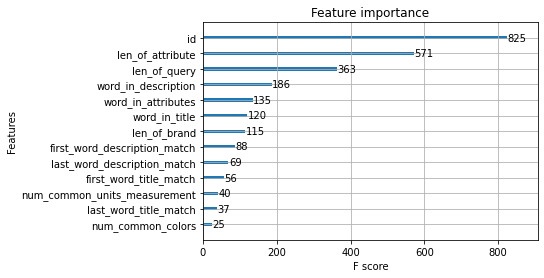

In [104]:
plot_importance(xg_reg)
plt.show() 

### 5.3.2 Avg Word

In [105]:
#xgboost
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', learning_rate = 0.1,max_depth = 5)
tmp=datetime.now()
xg_reg.fit(X2,y2)
# y_pred_xg = xg_reg.predict(X_test)
# print(math.sqrt(mean_squared_error(y_test, y_pred_xg)))
print(math.sqrt(-cross_val_score(xg_reg, X2, y2, scoring='neg_mean_squared_error', cv=10).mean()))
print((datetime.now()-tmp).total_seconds())

0.5213290392625874
55.36807


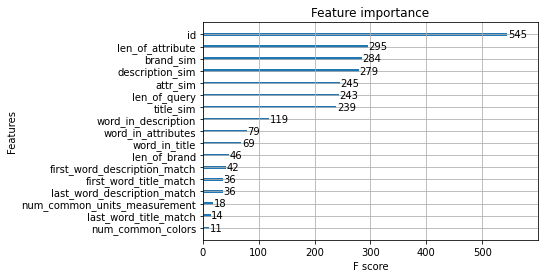

In [106]:
plot_importance(xg_reg)
plt.show() 

### 5.3.3 TF_IDF


0.5107661228901149
86.906755


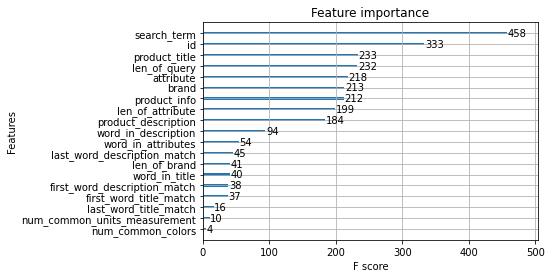

In [107]:
#xgboost
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', learning_rate = 0.1,max_depth = 5)
tmp=datetime.now()
xg_reg.fit(X3,y3)
# y_pred_xg = xg_reg.predict(X_test)
# print(math.sqrt(mean_squared_error(y_test, y_pred_xg)))
print(math.sqrt(-cross_val_score(xg_reg, X3, y3, scoring='neg_mean_squared_error', cv=10).mean()))
print((datetime.now()-tmp).total_seconds())
plot_importance(xg_reg)
plt.show() 

### 5.3.4 Sentence Embedding

0.5211020877842513
53.559729


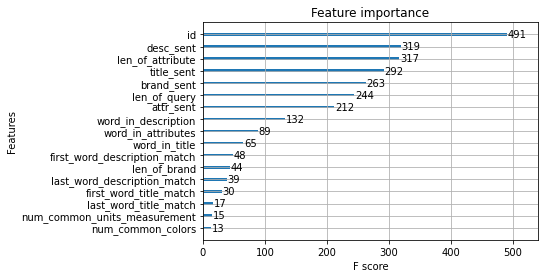

In [82]:
#xgboost
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', learning_rate = 0.1,max_depth = 5)
tmp=datetime.now()
xg_reg.fit(X4,y4)
# y_pred_xg = xg_reg.predict(X_test)
# print(math.sqrt(mean_squared_error(y_test, y_pred_xg)))
print(math.sqrt(-cross_val_score(xg_reg, X4, y4, scoring='neg_mean_squared_error', cv=10).mean()))
print((datetime.now()-tmp).total_seconds())
plot_importance(xg_reg)
plt.show() 

## 5.5 Light GBM

In [83]:
import lightgbm

5.5.1 No Embedding

In [109]:
mod_lgbm = lightgbm.LGBMRegressor(max_depth=3,learning_rate=0.1)
tmp=datetime.now()
mod_lgbm.fit(X1,y1)
print(math.sqrt(-cross_val_score(mod_lgbm, X1, y1, scoring='neg_mean_squared_error', cv=10).mean()))
print((datetime.now()-tmp).total_seconds())

0.5156396172720061
5.17835


### 5.5.2 Avg Word

In [110]:
mod_lgbm = lightgbm.LGBMRegressor(max_depth=3,learning_rate=0.1)
tmp=datetime.now()
mod_lgbm.fit(X2,y2)
print(math.sqrt(-cross_val_score(mod_lgbm, X2, y2, scoring='neg_mean_squared_error', cv=10).mean()))
print((datetime.now()-tmp).total_seconds())

0.5186430732896095
4.626038


### 5.5.3 TF-IDF

In [85]:
mod_lgbm = lightgbm.LGBMRegressor(max_depth=3,learning_rate=0.1)
tmp=datetime.now()
mod_lgbm.fit(X3,y3)
print(math.sqrt(-cross_val_score(mod_lgbm, X3, y3, scoring='neg_mean_squared_error', cv=10).mean()))
print((datetime.now()-tmp).total_seconds())

0.5127894183985278
6.54635


### 5.5.4 Sentence Embedding

In [86]:
mod_lgbm = lightgbm.LGBMRegressor(max_depth=3,learning_rate=0.1)
tmp=datetime.now()
mod_lgbm.fit(X4,y4)
print(math.sqrt(-cross_val_score(mod_lgbm, X4, y4, scoring='neg_mean_squared_error', cv=10).mean()))
print((datetime.now()-tmp).total_seconds())

0.5184844305141089
4.128092


In [112]:
print('Done')

Done
